# Introducción

Este cuaderno tiene como objetivo documentar el proceso de predicción de precios de arriendo de apartamentos en la ciudad de Ibagué, utilizando algoritmos de machine learning. A lo largo del análisis, se realiza una exhaustiva ingeniería de características para transformar y adecuar los datos, así como la imputación de valores faltantes y la depuración de la información. Todo esto permite construir un conjunto de datos robusto y confiable, que facilita la obtención de resultados precisos y útiles para la toma de decisiones en el mercado inmobiliario local.

Los datos analizados en este estudio provienen de la recopilación más actualizada realizada mediante técnicas de web scraping, usando la plataforma Finca Raíz, cuyo proceso y consideraciones se encuentran detalladamente descritos en el archivo `01_WSFincaRaizIbague.ipynb`. Esta información constituye la base fundamental para el desarrollo y validación de los modelos predictivos presentados a continuación.

# Preparación del entorno de trabajo

Se realiza la carga de las librerías necesarias:

In [1]:
# procesamiento de datos
import pandas as pd
import numpy as np

# visualización de datos
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import folium

# transformación de datos
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# machine learning
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# evaluación de modelos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# manejo de fechas y advertencias
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

Se define de fecha más reciente de la información descargada.

In [2]:
# busqueda del archivo más reciente
archivos_apartamentos = [f for f in os.listdir() if f.endswith('_apartamentos_ibague.csv')]
if archivos_apartamentos:
    # Encontrar el archivo con la fecha de modificación más reciente
    archivo_mas_reciente = max(archivos_apartamentos, key=lambda f: os.path.getmtime(f))
    fecha_actual = datetime.fromtimestamp(os.path.getmtime(archivo_mas_reciente)).strftime('%Y%m%d')
else:
    fecha_actual = None  # No se encontró el archivo
# impresión del resultado
print(fecha_actual[:4] + '-' + fecha_actual[4:6] + '-' + fecha_actual[6:8])

2025-09-12


# Preparación de datos

Se inicia con la importación de la información:

In [3]:
# lectura de datos
datos_apartamentos = pd.read_csv(f'{fecha_actual}_apartamentos_ibague.csv')
# revisión de observaciones al azar
datos_apartamentos.sample(10, random_state=42)

,Identificador,Área Construida (metros cuadrados),Área Privada (metros cuadrados),Habitaciones,Baños,Estrato,Parqueaderos,Antigüedad,Administración,Piso N°,Estado,Cantidad de pisos,Latitud,Longitud,Precio
44,191707560,49.0,NaN,2,2,3,NaN,1 a 8 años,171000.0,NaN,Usado,NaN,4.449719,-75.143251,529000
47,191344794,200.0,196.0,4,3,3,NaN,16 a 30 años,NaN,NaN,NaN,NaN,4.440993,-75.226098,3000000
4,192592371,40.0,35.0,2,1,3,NaN,1 a 8 años,134000.0,NaN,Usado,NaN,4.419924,-75.170624,616000
55,192650939,120.0,NaN,3,3,3,1.0,16 a 30 años,NaN,4.0,NaN,NaN,4.439575,-75.228605,1500000
26,192835541,75.0,75.0,3,2,2,NaN,16 a 30 años,NaN,4.0,Usado,NaN,4.446831,-75.194156,1400000
64,192861055,90.0,NaN,3,1,3,NaN,1 a 8 años,NaN,1.0,Usado,NaN,4.437587,-75.167863,800000
73,192676131,106.0,106.0,3,2,110,1.0,NaN,NaN,NaN,NaN,NaN,4.437001,-75.206974,1950000
10,192737003,56.0,50.0,3,2,3,1.0,9 a 15 años,185000.0,NaN,Usado,NaN,4.444200,-75.166085,615000
40,192666097,57.0,NaN,2,2,3,NaN,1 a 8 años,NaN,5.0,Usado,NaN,4.418958,-75.170131,1100000
107,192747728,38.0,38.0,1,1,4,1.0,9 a 15 años,NaN,NaN,Usado,NaN,4.436552,-75.205586,1250000


## Análisis exploratorio de datos

Se revisa la información general de la base:

In [4]:
datos_apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Identificador                       120 non-null    int64  
 1   Área Construida (metros cuadrados)  120 non-null    float64
 2   Área Privada (metros cuadrados)     90 non-null     float64
 3   Habitaciones                        120 non-null    int64  
 4   Baños                               120 non-null    int64  
 5   Estrato                             120 non-null    int64  
 6   Parqueaderos                        81 non-null     float64
 7   Antigüedad                          109 non-null    object 
 8   Administración                      50 non-null     float64
 9   Piso N°                             48 non-null     float64
 10  Estado                              84 non-null     object 
 11  Cantidad de pisos                   8 non-nul

Se evidencia la presencia de valores faltantes en varias columnas. Para más detalle, se calcula el porcentaje de valores faltantes por cada columna que tuvo un mínimo de 1 faltante:

In [5]:
porcentaje_faltantes = (datos_apartamentos.isnull().sum() / len(datos_apartamentos)) * 100
porcentaje_faltantes[porcentaje_faltantes > 0].apply(lambda x: f"{x:.2f}")

Área Privada (metros cuadrados)    25.00
Parqueaderos                       32.50
Antigüedad                          9.17
Administración                     58.33
Piso N°                            60.00
Estado                             30.00
Cantidad de pisos                  93.33
dtype: object

Se observa lo siguiente:

- `Área Privada (metros cuadrados)` está muy relacionada con `Área Construida (metros cuadrados)`, algo que se revisará más adelante con detalle, por lo que puede ser viable excluirla del análisis.
- `Parqueaderos` es, probablemente, una variable con muy poca variabilidad, por lo que también puede excluirse, eventualmente.
- `Antigüedad` tiene muy pocos valores faltantes, por lo que puede ser viable una imputación. Desde luego, considerando que se trata de una variable categórica, al final se terminará transformado.
- `Piso N°` tiene un porcentaje muy alto de valores faltantes, por lo que puede excluirse.
- `Estado` tiene una situación similar a la variable anterior.
- `Cantidad de pisos` tiene un porcentaje de faltantes alto, por lo que también es viable exluirlo.

Ya se revisarán en detalle las variables. Por el momento, se revisa que no existan filas duplicadas:

In [6]:
print(f'Hay {datos_apartamentos.duplicated().sum()} filas duplicadas.')

Hay 0 filas duplicadas.


A continuación, se definen las variables numéricas y categóricas desde el punto de vista conceptual. Es decir, se hace la clasificación que tiene sentido desde el punto de vista económico más allá de la lectura que hace Python:

In [7]:
variables_numericas=[
    'Área Construida (metros cuadrados)', 'Área Privada (metros cuadrados)', 'Habitaciones',
    'Baños', 'Parqueaderos', 'Administración', 'Cantidad de pisos', 'Latitud', 'Longitud', 'Precio'
]
variables_categoricas = [col for col in datos_apartamentos.columns if col not in variables_numericas and col != 'Identificador']

De esta forma, se inicia con la revisión de las variables categóricas:

In [8]:
# conversión a texto de variables categóricas leídas como numéricas
for var in variables_categoricas:
    datos_apartamentos[var] = datos_apartamentos[var].astype(str)

# reemplazo de los valores nulos como "Sin información"
for var in variables_categoricas:
    datos_apartamentos[var] = datos_apartamentos[var].replace(['nan', 'None', 'NaN'], "Sin información")
    datos_apartamentos[var] = datos_apartamentos[var].replace({pd.NA: "Sin información", None: "Sin información"})

# para la variable estrato, conversión de las categorías nulas
if 'Estrato' in datos_apartamentos.columns:
    datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].replace("Sin Definir", "Sin información")
    datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].replace("110", "Sin información")

# creación de diccionario para almacenar las frecuencias relativas
frecuencias_relativas = {}

# cálculo de frecuencias relativas
for var in variables_categoricas:
    frecuencias_relativas[var] = datos_apartamentos[var].value_counts(normalize=True, dropna=False) * 100

# creación de gráfico interactivo
fig = go.Figure()

# adicion de una barra para cada variable categórica
for i, var in enumerate(variables_categoricas):
    valores = frecuencias_relativas[var].index.astype(str)
    frecuencias = frecuencias_relativas[var].values
    fig.add_trace(
        go.Bar(
            x=valores,
            y=frecuencias,
            name=var,
            visible=True if i == 0 else False,
            hovertemplate='%{y:.2f}%<extra></extra>'
        )
    )

# creación los botones para la barra desplegable
botones = []
for i, var in enumerate(variables_categoricas):
    visibilidad = [False] * len(variables_categoricas)
    visibilidad[i] = True
    botones.append(
        dict(
            label=var,
            method="update",
            args=[{"visible": visibilidad},
                  {"title": f"Frecuencia relativa (%) de {var}"}]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=botones,
            x=1.15,
            y=1.15
        )
    ],
    title=f"Frecuencia relativa (%) de {variables_categoricas[0]}",
    xaxis_title="Categoría",
    yaxis_title="Frecuencia relativa (%)",
    showlegend=False,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False, showline=False),
    yaxis=dict(showgrid=False, zeroline=False, showline=False)
)

# impresión del gráfico
fig.show()

En el caso del estrato, la mayor parte de los apartamentos pertenece a los estratos 3 y 4. Menos del 1% aparece sin información, lo que significa que es más viable realizar una imputación de esos casos de acuerdo al sector en el que se encuentre el apartamento.

En el caso de la antigüedad, la mayor parte de los apartamentos tiene de 1 a 15 años de antigüedad. Cerca del 7% de los apartamentos aparece sin información, lo que hace viable realizar una imputación de acuerdo a otras características similares.

En el número de piso del apartamento, más de la mitad de observaciones no tiene información, de forma que es mejor eliminar la variable. Una situación similar se presenta con el estado del apartamento, aunque su porcentaje de faltantes es más bajo, sigue siendo demasiado alto para considerar una imputación.

A continuación, se revisan las variables numéricas:

In [9]:
# creación de la figura
fig = go.Figure()

# adición del diagrama de violín para cada variable numérica
for i, var in enumerate(variables_numericas):
    fig.add_trace(
        go.Violin(
            y=datos_apartamentos[var],
            name=var,
            box_visible=True,
            meanline_visible=True,
            line_color='blue',
            fillcolor='lightblue',
            opacity=0.7,
            visible=True if i == 0 else False
        )
    )

# creación de los botones para la barra desplegable
botones = []
for i, var in enumerate(variables_numericas):
    visibilidad = [False] * len(variables_numericas)
    visibilidad[i] = True
    botones.append(
        dict(
            label=var,
            method="update",
            args=[{"visible": visibilidad},
                  {"title": f"Distribución de {var} (diagrama de violín)"}]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=botones,
            x=1.15,
            y=1.15
        )
    ],
    title=f"Distribución de {variables_numericas[0]}",
    yaxis_title="Valor",
    showlegend=False,
    plot_bgcolor='white', 
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False, showline=False),
    yaxis=dict(showgrid=True, zeroline=False, showline=False)
)

# impresión del gráfico
fig.show()

Se evidencia la presencia de valores atípicos (que ya serán revisados formalmente) en las variables de área (tanto construida como privada) y parqueaderos, latitud y longitud. También sucede con el precio, aunque es ese caso es un comportamiento esperado y se recomienda escalarla en vez de buscar algún tipo de imputación.

Ahora, se revisa la correlación entre variables mediante un mapa de calor de correlaciones y el uso de diagramas de dispersión entre variables:

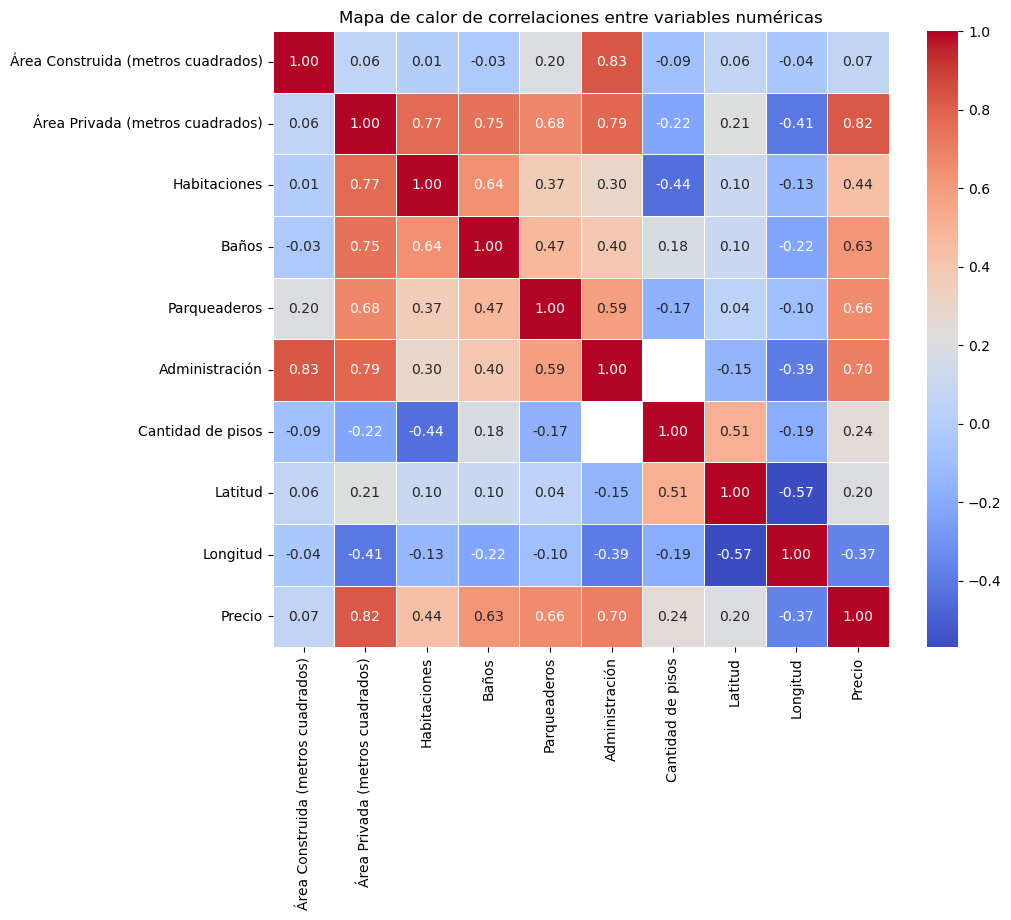

interactive(children=(Dropdown(description='variable_x', options=('Área Construida (metros cuadrados)', 'Área …

<function __main__.<lambda>(variable_x, variable_y)>

In [10]:
###############
# Mapa de calor
###############

# cálculo de la matriz de correlación
matriz_correlacion = datos_apartamentos[variables_numericas].corr()

# configuración del tamaño de la figura
plt.figure(figsize=(10, 8))

# generación del mapa de calor
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

plt.title('Mapa de calor de correlaciones entre variables numéricas')
plt.show()

#############################################
# Diagrama de puntos interactivo
#############################################

# uso de interact para la creación de la visualización
interact(
    lambda variable_x, variable_y: go.Figure(
        data=[
            go.Scatter(
                x=datos_apartamentos[variable_x],
                y=datos_apartamentos[variable_y],
                mode='markers',
                marker=dict(color='rgba(99, 110, 250, 0.7)', size=8, line=dict(width=1, color='DarkSlateGrey'))
            )
        ],
        layout=go.Layout(
            title=dict(
                text=f"Diagrama de dispersión:<br>{variable_x} vs {variable_y}<br>Correlación lineal: {datos_apartamentos[variable_x].corr(datos_apartamentos[variable_y]):.2f}",
                x=0.5,
                xanchor='center'
            ),
            xaxis_title=variable_x,
            yaxis_title=variable_y,
            plot_bgcolor='white',
            paper_bgcolor='white'
        )
    ).show(),
    variable_x=variables_numericas,
    variable_y=variables_numericas
)

Contrario a lo esperado, la correlación entre el área construida y el área privada no es tan alta. Esto se debe a la presencia de valores atípicos influyentes que cambian la correlación. Se concluye, entonces, que se puede eliminar área privada, que es la variable con más valores faltantes, pero es necesario realizar un tratamiento a los valores atípicos del área construida.

En general, la presencia de valores atípicos tiene efectos notables en la determinación de correlaciones entre variables. De ahí que muchas correlaciones sean más bien bajas. Algunas correlaciones altas son engañosas, como en el caso de cantidad de pisos y administración, pues se trata de muy pocos datos. La relación de administración con las áreas es extraña, ya que graficamente no se refleja lo mismo que el cálculo de correlación.

Con respecto a las coordenadas geográficas, se requiere una revisión adicional desde el punto de vista geográfico. La siguiente es la graficación de los puntos en el mapa:

In [11]:
# definición del centro aproximado de Ibagué
centro_ibague = [4.438889, -75.232222]

# creación del mapa base
mapa_ibague = folium.Map(location=centro_ibague, zoom_start=12, tiles='cartodbpositron')

# adición de los puntos de los apartamentos al mapa
for idx, fila in datos_apartamentos.iterrows():
    lat = fila['Latitud']
    lon = fila['Longitud']
    if not (pd.isnull(lat) or pd.isnull(lon)):
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=f"Precio: {fila['Precio']:,}"
        ).add_to(mapa_ibague)

# impresión del mapa
mapa_ibague

Hay un dato que claramente no fue ubicado en Ibagué. Con exactitud, se determina la proporción:

In [12]:
# definición de los límites aproximados de la ciudad
lat_min = 4.35
lat_max = 4.55
lon_min = -75.30
lon_max = -75.10

# creación de variable auxiliar que identifica apartamentos fuera de la ciudad
datos_apartamentos['fuera_ciudad'] = (
    ~(
        (datos_apartamentos['Latitud'] >= lat_min) & (datos_apartamentos['Latitud'] <= lat_max) &
        (datos_apartamentos['Longitud'] >= lon_min) & (datos_apartamentos['Longitud'] <= lon_max)
    )
).astype(int)

# cálculo de la proporción y el número absoluto
proporcion_fuera = datos_apartamentos['fuera_ciudad'].mean()
cantidad_fuera = datos_apartamentos['fuera_ciudad'].sum()

# impresión del resultado
print(f"Proporción de apartamentos fuera de Ibagué: {proporcion_fuera:.2%}")
print(f"Número absoluto de apartamentos fuera de Ibagué: {cantidad_fuera}")

Proporción de apartamentos fuera de Ibagué: 0.83%
Número absoluto de apartamentos fuera de Ibagué: 1


Debido a que la proporción y cantidad de apartamentos con coordenadas fuera de Ibagué es muy bajo, se puede eliminar las observaciones por fuera de la ciudad.

## Ingeniería de características

### Eliminación de variables

A partir del análisis exploratorio previo, en el que se detectaron variables con alta proporción de valores faltantes o que no aportaban información, se decide eliminar las siguientes variables:

In [13]:
datos_apartamentos = datos_apartamentos.drop(columns=[
    'Piso N°', 'Estado', 'Cantidad de pisos', 'Área Privada (metros cuadrados)', 'Administración', 'Parqueaderos'
    ])

De esta forma, la nueva estructura de la base es la siguiente:

In [14]:
datos_apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Identificador                       120 non-null    int64  
 1   Área Construida (metros cuadrados)  120 non-null    float64
 2   Habitaciones                        120 non-null    int64  
 3   Baños                               120 non-null    int64  
 4   Estrato                             120 non-null    object 
 5   Antigüedad                          120 non-null    object 
 6   Latitud                             120 non-null    float64
 7   Longitud                            120 non-null    float64
 8   Precio                              120 non-null    int64  
 9   fuera_ciudad                        120 non-null    int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 9.5+ KB


### Exclusión de coordenadas fuera de la ciudad

Se decide excluir los apartamentos que se encuentran fuera de la ciudad. No se recomienda realizar una imputación en estos casos. Además, la proporción de apartamentos fuera de la ciudad son muy pocos.

In [15]:
# filtro para excluir casos fuera de la ciudad
datos_apartamentos=datos_apartamentos[datos_apartamentos['fuera_ciudad']!=1]
# eliminación de la variable
del datos_apartamentos['fuera_ciudad']

### Variables categóricas

En la base quedaron las siguientes variables categóricas:

In [16]:
# identificación de variables
variables_categoricas = datos_apartamentos.select_dtypes(include=['object', 'category']).columns.tolist()
print("Variables categóricas restantes:", variables_categoricas)

Variables categóricas restantes: ['Estrato', 'Antigüedad']


Aunque la variable estrato podría interpretarse de forma numérica para facilidad de uso, no es recomendable porque el salto del precio entre estratos no es igual entre los estratos bajos (p.ej. 1 y 2) y los estratos altos (p.ej. 5 y 6). Por lo tanto, se prefiere seguirlo tomando como una variable categórica. De esta forma, para las variables que quedaron, se implementa el procedimiento de one-hot encoding. Antes de hacerlo, se imputan los faltantes de información para cada variable.

#### Imputación de valores faltantes

Iniciando con la variable estrato, se inicia con la identificación de los valores faltantes.

In [17]:
# conversión de valores '101' a faltantes (variable de tipo texto)
datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].replace('110', np.nan)
# tabla de frecuencia incluyendo faltantes
pd.DataFrame(datos_apartamentos['Estrato'].value_counts(dropna=False).sort_index()).reset_index()

,Estrato,count
0,2,9
1,3,60
2,4,41
3,5,6
4,6,2
5,Sin información,1


Para realizar la imputación de los valores faltantes de estrato, se utiliza el algoritmo de los _k_ vecinos más cercanos para aprovechar los datos de las coordenadas de apartamentos. Así, se asigna el estrato del apartamento más cercano.

Para determinar el número de vecinos, se revisa graficamente el comportamiento del error cuadrático medio con respecto al número de vecinos:

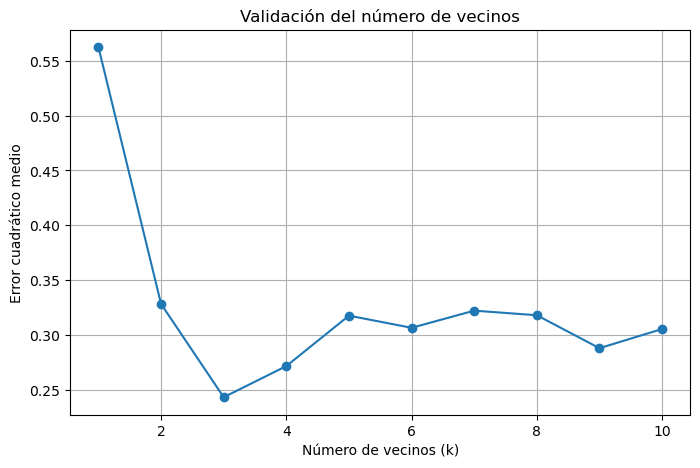

In [18]:
# conversión de casos con 'Sin información' a nulos
datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].replace('Sin información', np.nan)

# selección de las variables necesarias
datos_validacion = datos_apartamentos[['Longitud', 'Latitud', 'Estrato']].copy()
datos_validacion['Estrato'] = pd.to_numeric(datos_validacion['Estrato'], errors='coerce')

# definición del rango de vecinos a probar
vecinos_rango = range(1, 11)
errores = []

# se toma solo las filas donde Estrato no es nulo para simular el proceso de imputación
datos_no_nulos = datos_validacion.dropna(subset=['Estrato'])

# se enmascaran aleatoriamente algunos valores de 'Estrato' para validar el error de imputación
np.random.seed(42)
mask = np.random.rand(len(datos_no_nulos)) < 0.2
datos_no_nulos_masked = datos_no_nulos.copy()
datos_no_nulos_masked.loc[mask, 'Estrato'] = np.nan

# cálculo del error para cada número de vecinos
for k in vecinos_rango:
    imputer = KNNImputer(n_neighbors=k)
    imputados = imputer.fit_transform(datos_no_nulos_masked)
    # Solo se evalúan los valores que fueron enmascarados
    valores_reales = datos_no_nulos['Estrato'].values[mask]
    valores_imputados = imputados[mask, 2]
    # Error cuadrático medio
    error = np.mean((valores_reales - valores_imputados) ** 2)
    errores.append(error)

plt.figure(figsize=(8,5))
plt.plot(vecinos_rango, errores, marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error cuadrático medio')
plt.title('Validación del número de vecinos')
plt.grid(True)
plt.show()

Es evidente que el error de minimiza radicalmente para 3 vecinos, por lo que se deja ese valor.

In [19]:
if datos_apartamentos['Estrato'].isna().sum() >= 1:
    # creación de un DataFrame temporal con las variables necesarias para la imputación
    datos_imputacion = datos_apartamentos[['Longitud', 'Latitud', 'Estrato']].copy()
    # conversión de la variable Estrato a numérica para el algoritmo KNN
    datos_imputacion['Estrato'] = pd.to_numeric(datos_imputacion['Estrato'], errors='coerce')
    # aplicación de la imputación con 3 vecinos
    imputer = KNNImputer(n_neighbors=3)
    datos_imputados = imputer.fit_transform(datos_imputacion)
    # actualización de la variable Estrato en el DataFrame original
    datos_apartamentos['Estrato'] = datos_imputados[:, 2]
    # conversión de vuelta a entero y luego a string para mantener el formato original
    datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].astype(int).astype(str)
    print("Imputación completada con 3 vecinos.")
else:
    print("No hay faltantes")

# impresión para revisión
pd.DataFrame(datos_apartamentos['Estrato'].value_counts(dropna=False).sort_index()).reset_index()

Imputación completada con 3 vecinos.


,Estrato,count
0,2,9
1,3,60
2,4,42
3,5,6
4,6,2


A continuación, se imputan los casos faltantes de `Antigüedad`:

In [20]:
# conversión de casos sin información a nulos
datos_apartamentos.loc[datos_apartamentos['Antigüedad'] == 'Sin información', 'Antigüedad'] = np.nan
# cálculo de la mode de antigüedad
moda_antiguedad = datos_apartamentos['Antigüedad'].mode()[0]
# imputación de nulos con la moda
datos_apartamentos['Antigüedad'] = datos_apartamentos['Antigüedad'].fillna(moda_antiguedad)
# revisión de la nueva tabla de frecuencias
pd.DataFrame(datos_apartamentos['Antigüedad'].value_counts(dropna=False).sort_index()).reset_index()

,Antigüedad,count
0,1 a 8 años,73
1,16 a 30 años,11
2,9 a 15 años,20
3,menor a 1 año,13
4,más de 30 años,2


Ya con las variables imputadas, se realizar el one-hot encoding:

In [21]:
# one hot encoding para las variables 'Estrato' y 'Antigüedad'
datos_apartamentos = pd.get_dummies(datos_apartamentos, columns=['Estrato', 'Antigüedad'], prefix=['Estrato', 'Antigüedad'])
# revisión de la nueva estructura
datos_apartamentos.info()


<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 119
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Identificador                       119 non-null    int64  
 1   Área Construida (metros cuadrados)  119 non-null    float64
 2   Habitaciones                        119 non-null    int64  
 3   Baños                               119 non-null    int64  
 4   Latitud                             119 non-null    float64
 5   Longitud                            119 non-null    float64
 6   Precio                              119 non-null    int64  
 7   Estrato_2                           119 non-null    bool   
 8   Estrato_3                           119 non-null    bool   
 9   Estrato_4                           119 non-null    bool   
 10  Estrato_5                           119 non-null    bool   
 11  Estrato_6                           119 non-null  

### Variables numéricas

#### Identificación de datos atípicos

Se realiza una identificación de valores atípicos. La única variable para la que se sospecha esta situación es el área construida, por lo que se identifican los casos atípicos según el criterio de rango intercuantílico.

In [22]:
# cálculo de los cuantiles 5 y 95
q01 = datos_apartamentos['Área Construida (metros cuadrados)'].quantile(0.01)
q95 = datos_apartamentos['Área Construida (metros cuadrados)'].quantile(0.95)

# se usan ambos umbrales para identificar atípicos
datos_apartamentos['atipico_area'] = (
    (datos_apartamentos['Área Construida (metros cuadrados)'] < q01) |
    (datos_apartamentos['Área Construida (metros cuadrados)'] > q95)
).astype(int)

proporcion_atipicos = datos_apartamentos['atipico_area'].mean()
print(f'Proporción de atípicos identificados: {proporcion_atipicos*100:.2f}%')

Proporción de atípicos identificados: 6.72%


#### Imputación de valores atípicos

Se realiza la imputación de los valores atípicos identificados:

In [23]:
# imputación de valores atípicos
media_area = datos_apartamentos.loc[datos_apartamentos['atipico_area'] == 0, 'Área Construida (metros cuadrados)'].mean()
datos_apartamentos.loc[datos_apartamentos['atipico_area'] == 1, 'Área Construida (metros cuadrados)'] = media_area

# eliminación de la columna auxiliar
datos_apartamentos = datos_apartamentos.drop(columns=['atipico_area'])

# impresión del resumen estadístico
datos_apartamentos['Área Construida (metros cuadrados)'].describe()


count    119.000000
mean      74.267387
std       32.265152
min       36.000000
25%       56.000000
50%       68.000000
75%       80.000000
max      212.000000
Name: Área Construida (metros cuadrados), dtype: float64

## Base definitiva

Se consolida la base de datos definitiva para el modelamiento:

In [24]:
# listado de columnas con nombre conocido
columnas_base = [
    'Área Construida (metros cuadrados)', 'Habitaciones', 'Baños',
    'Latitud', 'Longitud', 'Precio'
]

# selección de columnas del one-hot encodign
columnas_base += [col for col in datos_apartamentos.columns if col.startswith('Estrato_') and 'Identificador' not in col]
columnas_base += [col for col in datos_apartamentos.columns if col.startswith('Antigüedad_') and 'Identificador' not in col]

base_final = datos_apartamentos[columnas_base]
base_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 119
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Área Construida (metros cuadrados)  119 non-null    float64
 1   Habitaciones                        119 non-null    int64  
 2   Baños                               119 non-null    int64  
 3   Latitud                             119 non-null    float64
 4   Longitud                            119 non-null    float64
 5   Precio                              119 non-null    int64  
 6   Estrato_2                           119 non-null    bool   
 7   Estrato_3                           119 non-null    bool   
 8   Estrato_4                           119 non-null    bool   
 9   Estrato_5                           119 non-null    bool   
 10  Estrato_6                           119 non-null    bool   
 11  Antigüedad_1 a 8 años               119 non-null  

# Modelamiento

## Regresión lineal

Se inicia realizando el proceso

In [ ]:
# definición de variables predictoras y variable objetivo
X = base_final.drop('Precio', axis=1)
y = base_final['Precio']

# Configuraciones de proporciones de entrenamiento/prueba
proporciones = [0.2, 0.3, 0.4]

for test_size in proporciones:
    print(f"\nValidación con conjunto de prueba = {int(test_size*100)}% y entrenamiento = {int((1-test_size)*100)}%")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    score_entrenamiento = modelo.score(X_train, y_train)
    score_prueba = modelo.score(X_test, y_test)
    print(f"R^2 en entrenamiento: {score_entrenamiento:.4f}")
    print(f"R^2 en prueba: {score_prueba:.4f}")

# Validación cruzada con KFold
print("\nValidación cruzada con KFold (5 particiones):")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
modelo = LinearRegression()
scores = cross_val_score(modelo, X, y, cv=kf, scoring='r2')
print(f"R^2 promedio: {np.mean(scores):.4f}")
print(f"Desviación estándar: {np.std(scores):.4f}")

# Entrenamiento final del modelo con todos los datos
modelo.fit(X, y)
print("\nModelo final entrenado con todos los datos.")



Validación con conjunto de prueba = 20% y entrenamiento = 80%
R^2 en entrenamiento: 0.7131
R^2 en prueba: 0.5903

Validación con conjunto de prueba = 30% y entrenamiento = 70%
R^2 en entrenamiento: 0.7078
R^2 en prueba: 0.5833

Validación con conjunto de prueba = 40% y entrenamiento = 60%
R^2 en entrenamiento: 0.7227
R^2 en prueba: 0.4598

Validación cruzada con KFold (5 particiones):
R^2 promedio: 0.3745
Desviación estándar: 0.3223

Modelo final entrenado con todos los datos.
